# Tweet emotion analysis using NLP

In [1]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from sklearn.preprocessing import Normalizer

In [2]:
filepath = r".\content\data\NRC-emotion-lexicon-wordlevel.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], sep='\t')
emolex_words = emolex_df.pivot(index='word',columns='emotion',values='association').reset_index()
emolex_words

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,NaN,0,0,0,0,0,0,0,0,0,0
1,aback,0,0,0,0,0,0,0,0,0,0
2,abacus,0,0,0,0,0,0,0,0,0,1
3,abandon,0,0,0,1,0,1,0,1,0,0
4,abandoned,1,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
14177,zone,0,0,0,0,0,0,0,0,0,0
14178,zoo,0,0,0,0,0,0,0,0,0,0
14179,zoological,0,0,0,0,0,0,0,0,0,0
14180,zoology,0,0,0,0,0,0,0,0,0,0


In [3]:
tweetsfile = r'.\content\data\tweets.csv'

In [4]:
tweets_df = pd.read_csv(tweetsfile)
tweets_df = tweets_df.dropna()
tweets_df.head()
print(tweets_df.shape)

(14516, 10)


In [5]:
tweets_df

,Unnamed: 0,Tweet User,Text,Retweets,Favorites,Replies,Datetime,FormattedDate,Hashtags,Permalink
0,0,ahappystitcher,@ScalaRadio @simonmayo #wfh Had a pottering ar...,0,1,0,7/10/2019,Wed Jul 10 10:03:05 +0000 2019,#wfh #workingfromhome #brokenarm,https://twitter.com/ahappystitcher/status/1148...
1,1,SufiSenses,#WFH #WorkingFromHome Whose home? Monsieur Lad...,0,0,0,7/12/2019,Fri Jul 12 15:20:29 +0000 2019,#WFH #WorkingFromHome #Loser #parklife #summer...,https://twitter.com/SufiSenses/status/11497000...
2,2,caboosecommons,Happy Friday! Let's start this weekend on the ...,0,0,0,7/12/2019,Fri Jul 12 12:05:04 +0000 2019,#breakfast #coffee #workingfromhome #workfromh...,https://twitter.com/caboosecommons/status/1149...
3,3,LisetteYOrellan,six conference calls today. BRING IT ON MONDAY...,0,0,0,7/15/2019,Mon Jul 15 13:49:24 +0000 2019,#WFH #workingfromhome #notalonetoday,https://twitter.com/LisetteYOrellan/status/115...
4,4,AzfarRizvi,#Workingfromhome has its perks! Pakoray . What...,0,3,0,7/17/2019,Wed Jul 17 13:19:41 +0000 2019,#Workingfromhome #WFH,https://twitter.com/AzfarRizvi/status/11514815...
...,...,...,...,...,...,...,...,...,...,...
14511,14511,utiliko,With #COVID-19 came the necessity to be able ...,1,3,0,2020-08-31 23:34:43+00:00,Mon Aug 31 23:34:43 +0000 2020,#COVID #WorkRemotely #CRM #Accounting #project...,https://twitter.com/utiliko/status/13005777901...
14512,14512,roblation,She: You always look so joyful in your videos....,0,0,0,2020-08-31 23:45:05+00:00,Mon Aug 31 23:45:05 +0000 2020,#Jesus #remotework #Truth #ShelterInPlace #Min...,https://twitter.com/roblation/status/130058039...
14513,14513,NexlinkComm,Whether your teams return to working on site o...,1,1,0,2020-08-31 23:49:02+00:00,Mon Aug 31 23:49:02 +0000 2020,#wevegotthesolution #nexlink #nexlinkcomm #rem...,https://twitter.com/NexlinkComm/status/1300581...
14514,14514,performetry,The future of work is here - @Pinterest take $...,1,2,0,2020-08-31 23:57:25+00:00,Mon Aug 31 23:57:25 +0000 2020,#futureofwork #remotework #performetry #digital,https://twitter.com/performetry/status/1300583...


In [6]:
# drop the index column
tweet_df = tweets_df.drop(['Unnamed: 0'],axis=1)
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14516 entries, 0 to 14515
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet User     14516 non-null  object
 1   Text           14516 non-null  object
 2   Retweets       14516 non-null  int64 
 3   Favorites      14516 non-null  int64 
 4   Replies        14516 non-null  int64 
 5   Datetime       14516 non-null  object
 6   FormattedDate  14516 non-null  object
 7   Hashtags       14516 non-null  object
 8   Permalink      14516 non-null  object
dtypes: int64(3), object(6)
memory usage: 1.1+ MB


In [7]:
def extract_review_emotion(df,column):
    new_df = df.copy()
    
#     filepath = "NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
    emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], sep='\t')
    emolex_words = emolex_df.pivot(index='word',columns='emotion',values='association').reset_index()
    
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")
    
    with tqdm(total=len(list(new_df.iterrows()))) as pbar:
        for i, row in new_df.iterrows():
            pbar.update(1)
            document = word_tokenize(new_df.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    new_df = pd.concat([new_df, emo_df], axis=1)

    return new_df

In [8]:
tweets_df.info()
# import fpdf

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14516 entries, 0 to 14515
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     14516 non-null  int64 
 1   Tweet User     14516 non-null  object
 2   Text           14516 non-null  object
 3   Retweets       14516 non-null  int64 
 4   Favorites      14516 non-null  int64 
 5   Replies        14516 non-null  int64 
 6   Datetime       14516 non-null  object
 7   FormattedDate  14516 non-null  object
 8   Hashtags       14516 non-null  object
 9   Permalink      14516 non-null  object
dtypes: int64(4), object(6)
memory usage: 1.2+ MB


In [9]:
tweets_df.head()

,Unnamed: 0,Tweet User,Text,Retweets,Favorites,Replies,Datetime,FormattedDate,Hashtags,Permalink
0,0,ahappystitcher,@ScalaRadio @simonmayo #wfh Had a pottering ar...,0,1,0,7/10/2019,Wed Jul 10 10:03:05 +0000 2019,#wfh #workingfromhome #brokenarm,https://twitter.com/ahappystitcher/status/1148...
1,1,SufiSenses,#WFH #WorkingFromHome Whose home? Monsieur Lad...,0,0,0,7/12/2019,Fri Jul 12 15:20:29 +0000 2019,#WFH #WorkingFromHome #Loser #parklife #summer...,https://twitter.com/SufiSenses/status/11497000...
2,2,caboosecommons,Happy Friday! Let's start this weekend on the ...,0,0,0,7/12/2019,Fri Jul 12 12:05:04 +0000 2019,#breakfast #coffee #workingfromhome #workfromh...,https://twitter.com/caboosecommons/status/1149...
3,3,LisetteYOrellan,six conference calls today. BRING IT ON MONDAY...,0,0,0,7/15/2019,Mon Jul 15 13:49:24 +0000 2019,#WFH #workingfromhome #notalonetoday,https://twitter.com/LisetteYOrellan/status/115...
4,4,AzfarRizvi,#Workingfromhome has its perks! Pakoray . What...,0,3,0,7/17/2019,Wed Jul 17 13:19:41 +0000 2019,#Workingfromhome #WFH,https://twitter.com/AzfarRizvi/status/11514815...


In [10]:
emotion_df = extract_review_emotion(tweets_df, 'Text')
# emotion_df.to_csv('twitter_emotion_sentiment.csv',index=False)

C:\Users\sandhyap\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [ ]:
# -0.75 to -1    -  Angry
# -0.5 to  -0.74 -  Frustrated
# -0.25 to -0.49 -  Unhappy
# -0.01 to -0.24 -  Dissatisfied/Confused
# 0 to 0.25      -  Indifferent
# 0.26 to 0.5    -  Satisfied
# 0.51 to 0.75   -  Happy
# 0.76 to 1.0    -  Thrilled

In [29]:
emotion_df.head()

,Unnamed: 0,Tweet User,Text,Retweets,Favorites,Replies,Datetime,FormattedDate,Hashtags,Permalink,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,0,ahappystitcher,@ScalaRadio @simonmayo #wfh Had a pottering ar...,0,1,0,7/10/2019,Wed Jul 10 10:03:05 +0000 2019,#wfh #workingfromhome #brokenarm,https://twitter.com/ahappystitcher/status/1148...,0,0,0,0,0,0,1,0,0,0
1,1,SufiSenses,#WFH #WorkingFromHome Whose home? Monsieur Lad...,0,0,0,7/12/2019,Fri Jul 12 15:20:29 +0000 2019,#WFH #WorkingFromHome #Loser #parklife #summer...,https://twitter.com/SufiSenses/status/11497000...,0,0,0,0,0,0,1,0,0,0
2,2,caboosecommons,Happy Friday! Let's start this weekend on the ...,0,0,0,7/12/2019,Fri Jul 12 12:05:04 +0000 2019,#breakfast #coffee #workingfromhome #workfromh...,https://twitter.com/caboosecommons/status/1149...,0,1,0,0,0,0,1,0,0,0
3,3,LisetteYOrellan,six conference calls today. BRING IT ON MONDAY...,0,0,0,7/15/2019,Mon Jul 15 13:49:24 +0000 2019,#WFH #workingfromhome #notalonetoday,https://twitter.com/LisetteYOrellan/status/115...,0,0,0,0,0,0,0,0,0,0
4,4,AzfarRizvi,#Workingfromhome has its perks! Pakoray . What...,0,3,0,7/17/2019,Wed Jul 17 13:19:41 +0000 2019,#Workingfromhome #WFH,https://twitter.com/AzfarRizvi/status/11514815...,0,0,0,0,0,0,1,0,0,0


In [38]:
pos=emotion_df['positive']!=0
neg=emotion_df['negative']!=0
emo_pos=emotion_df[pos]
emo_neg=emotion_df[neg]
emo_pos.head()

,Unnamed: 0,Tweet User,Text,Retweets,Favorites,Replies,Datetime,FormattedDate,Hashtags,Permalink,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,0,ahappystitcher,@ScalaRadio @simonmayo #wfh Had a pottering ar...,0,1,0,7/10/2019,Wed Jul 10 10:03:05 +0000 2019,#wfh #workingfromhome #brokenarm,https://twitter.com/ahappystitcher/status/1148...,0,0,0,0,0,0,1,0,0,0
1,1,SufiSenses,#WFH #WorkingFromHome Whose home? Monsieur Lad...,0,0,0,7/12/2019,Fri Jul 12 15:20:29 +0000 2019,#WFH #WorkingFromHome #Loser #parklife #summer...,https://twitter.com/SufiSenses/status/11497000...,0,0,0,0,0,0,1,0,0,0
2,2,caboosecommons,Happy Friday! Let's start this weekend on the ...,0,0,0,7/12/2019,Fri Jul 12 12:05:04 +0000 2019,#breakfast #coffee #workingfromhome #workfromh...,https://twitter.com/caboosecommons/status/1149...,0,1,0,0,0,0,1,0,0,0
4,4,AzfarRizvi,#Workingfromhome has its perks! Pakoray . What...,0,3,0,7/17/2019,Wed Jul 17 13:19:41 +0000 2019,#Workingfromhome #WFH,https://twitter.com/AzfarRizvi/status/11514815...,0,0,0,0,0,0,1,0,0,0
5,5,AliceHall_IM,Perk of WFH: lunchtime bacon sarnie (with a si...,0,6,0,7/23/2019,Tue Jul 23 10:57:00 +0000 2019,#agileworking #solicitorlife #workingfromhome,https://twitter.com/AliceHall_IM/status/115362...,0,0,0,0,0,0,1,0,0,0


In [43]:
emo_neg['Text']

6        A. Garden. Office. Can anyone else beat @stuar...
16       When your (home) office contains the cat's lit...
18       The #dog thinks I’m a true bore while working ...
25       Not often I sit in front of the computer, quit...
27       Working from home with this idiot, the struggl...
                               ...                        
14498    In some parts of the northern hemisphere, it f...
14499    The Japanese Yen may fall against its major co...
14502    The #WhenRemoteWorks hashtag got me thinking a...
14514    The future of work is here - @Pinterest take $...
14515    Cancelled TV Shows: Effective Immediately #buhbye
Name: Text, Length: 3365, dtype: object

In [12]:
temp = emotion_df[0:].sum(axis = 0, skipna = True)

In [13]:
print(temp)

Unnamed: 0                                               105349870
Tweet User       ahappystitcherSufiSensescaboosecommonsLisetteY...
Text             @ScalaRadio @simonmayo #wfh Had a pottering ar...
Retweets                                                     11716
Favorites                                                    60237
Replies                                                       6427
Datetime         7/10/20197/12/20197/12/20197/15/20197/17/20197...
FormattedDate    Wed Jul 10 10:03:05 +0000 2019Fri Jul 12 15:20...
Hashtags         #wfh #workingfromhome #brokenarm#WFH #WorkingF...
Permalink        https://twitter.com/ahappystitcher/status/1148...
anger                                                         1556
anticipation                                                  8206
disgust                                                        949
fear                                                          2206
joy                                                           

In [181]:
df_sum = pd.DataFrame(temp[10:])

In [182]:
df_sum

,0
anger,1556
anticipation,8206
disgust,949
fear,2206
joy,6020
negative,4459
positive,14638
sadness,1792
surprise,2476
trust,9223


<BarContainer object of 10 artists>

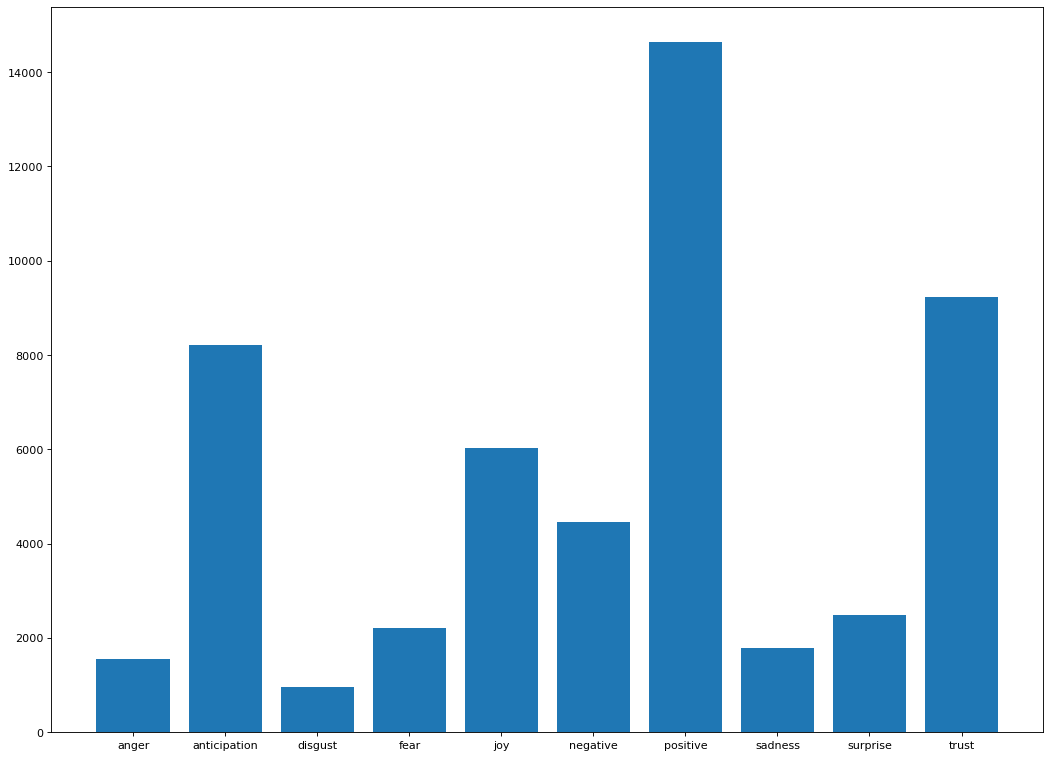

In [30]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.bar(df_sum.index,df_sum[0])

# Pro and Post Covid-19 

In [17]:
pro = r'.\content\data\before.csv.csv'
post = r'.\content\data\after_covid.csv'

In [18]:
pro_df = pd.read_csv(pro)
pro_df = pro_df.dropna()
post_df = pd.read_csv(post)
post_df = post_df.dropna()

In [19]:
emotion_pro = extract_review_emotion(pro_df, 'Text')
emotion_post = extract_review_emotion(post_df, 'Text')

C:\Users\sandhyap\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [44]:
pro_temp = emotion_pro[0:].sum(axis = 0, skipna = True)
pro_sum = pd.DataFrame(pro_temp[12:])
post_temp = emotion_post[0:].sum(axis = 0, skipna = True)
post_sum = pd.DataFrame(post_temp[10:])

In [184]:
pro_sum[5:7]
post_sum[5:7]

,0
negative,2606
positive,7307


In [176]:
pro_bi = pro_sum[5:7]
post_bi = post_sum[5:7]
pro_sum = pro_sum.drop(['positive','negative'])
post_sum = post_sum.drop(['positive','negative'])

In [177]:
pro_bi = pro_bi*100/pro_bi.sum()
pro_sum = pro_sum*100/pro_sum.sum()

In [178]:
post_bi = post_bi*100/post_bi.sum()
post_sum = post_sum*100/post_sum.sum()

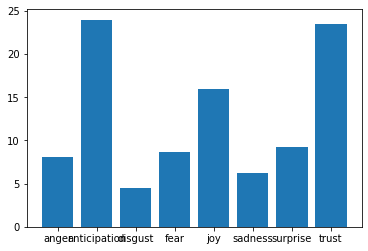

<BarContainer object of 8 artists>

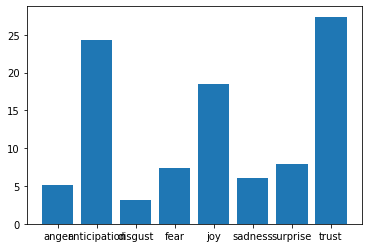

In [179]:
# figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.bar(pro_sum.index, pro_sum[0])
plt.show()
plt.bar(post_sum.index, post_sum[0])

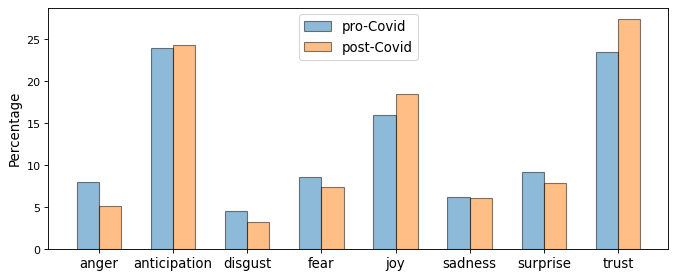

In [204]:
import numpy as np

figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
# width of the bars
barWidth = 0.3

# bar height
bars1 = pro_sum[0]
bars2 = post_sum[0]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, capsize=7, alpha=0.5, edgecolor = 'black', label='pro-Covid')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, capsize=7, alpha=0.5, edgecolor = 'black', label='post-Covid')
 
# general layout
plt.xticks([r + barWidth/2 for r in range(len(bars1))], pro_sum.index, fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(fontsize=12)
 
# Show graphic
plt.show()


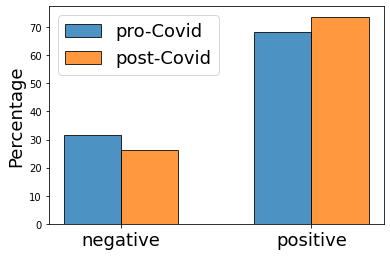

In [205]:
# figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
# width of the bars
barWidth = 0.3

# bar height
bars1 = pro_bi[0]
bars2 = post_bi[0]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, alpha=0.8, edgecolor = 'black',capsize=7, label='pro-Covid')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, alpha=0.8, edgecolor = 'black', capsize=7, label='post-Covid')
 
# general layout
plt.xticks([r + barWidth/2 for r in range(len(bars1))], pro_bi.index,fontsize=18)
plt.ylabel('Percentage',fontsize=18)
plt.legend(fontsize=18)
 
# Show graphic
plt.show()

# Keywords in Negative Sentiments for Post Covid data

In [185]:
# Get the tweets for negative sentiments only 
emo_neg=emotion_post[(emotion_post['negative']!=0) & (emotion_post['positive']==0)]
emo_neg.head()

,Unnamed: 0,Tweet User,Text,Retweets,Favorites,Replies,Datetime,FormattedDate,Hashtags,Permalink,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
8,8,ReneeJacobs__,When your (home) office contains the cat's lit...,0,0,0,2019-10-07,Mon Oct 07 14:54:45 +0000 2019,#CatsOfTwitter #catmum #notreallyanoffice #box...,https://twitter.com/ReneeJacobs__/status/11812...,0,0,0,0,0,1,0,0,0,0
20,20,frances_jisun,When you have kids banging on the door while y...,2,10,0,2020-02-18,Tue Feb 18 02:24:09 +0000 2020,#coronavirus #workingfromhome #WFH #cabinfever...,https://twitter.com/frances_jisun/status/12295...,1,0,1,1,0,1,0,1,1,0
22,22,AutumnTheAries,"For those of you that #WorkFromHome, what is t...",1,2,3,2020-02-10,Mon Feb 10 22:47:01 +0000 2020,#WorkFromHome #WFH #Podcast #PodernFamily #Atl...,https://twitter.com/AutumnTheAries/status/1227...,1,0,1,0,0,1,0,0,0,0
23,23,JoBellAuthor,“Stop writing and take me for walkies.” What d...,0,10,2,2020-02-07,Fri Feb 07 10:19:14 +0000 2020,#distractions #workingfromhome #writingcommuni...,https://twitter.com/JoBellAuthor/status/122572...,0,0,0,0,0,2,0,0,0,0
44,44,rinikulous,Still works quite admirably - @Alienware M17x ...,0,1,0,2020-04-30,Thu Apr 30 17:05:34 +0000 2020,#alienware #alienware #m17x #wfh #workingfromh...,https://twitter.com/rinikulous/status/12559061...,0,0,0,0,0,1,0,0,0,0


In [186]:
emo_neg.head()

,Unnamed: 0,Tweet User,Text,Retweets,Favorites,Replies,Datetime,FormattedDate,Hashtags,Permalink,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
8,8,ReneeJacobs__,When your (home) office contains the cat's lit...,0,0,0,2019-10-07,Mon Oct 07 14:54:45 +0000 2019,#CatsOfTwitter #catmum #notreallyanoffice #box...,https://twitter.com/ReneeJacobs__/status/11812...,0,0,0,0,0,1,0,0,0,0
20,20,frances_jisun,When you have kids banging on the door while y...,2,10,0,2020-02-18,Tue Feb 18 02:24:09 +0000 2020,#coronavirus #workingfromhome #WFH #cabinfever...,https://twitter.com/frances_jisun/status/12295...,1,0,1,1,0,1,0,1,1,0
22,22,AutumnTheAries,"For those of you that #WorkFromHome, what is t...",1,2,3,2020-02-10,Mon Feb 10 22:47:01 +0000 2020,#WorkFromHome #WFH #Podcast #PodernFamily #Atl...,https://twitter.com/AutumnTheAries/status/1227...,1,0,1,0,0,1,0,0,0,0
23,23,JoBellAuthor,“Stop writing and take me for walkies.” What d...,0,10,2,2020-02-07,Fri Feb 07 10:19:14 +0000 2020,#distractions #workingfromhome #writingcommuni...,https://twitter.com/JoBellAuthor/status/122572...,0,0,0,0,0,2,0,0,0,0
44,44,rinikulous,Still works quite admirably - @Alienware M17x ...,0,1,0,2020-04-30,Thu Apr 30 17:05:34 +0000 2020,#alienware #alienware #m17x #wfh #workingfromh...,https://twitter.com/rinikulous/status/12559061...,0,0,0,0,0,1,0,0,0,0


In [50]:
from nltk.tokenize import WordPunctTokenizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\sandhyap\Anaconda3\e
[nltk_data]     nvs\tensorflow_env\lib\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\sandhyap\Anacond
[nltk_data]     a3\envs\tensorflow_env\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\sandhyap\Anaconda3
[nltk_data]     \envs\tensorflow_env\lib\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [68]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [110]:
# Split the words from one tweet into unique elements
text=[x.lower().split() for x in emo_neg['Text']]

In [111]:
flat = []
for i in text:
    for j in i:
        flat.append(j)

In [112]:
flat=[i.strip('#@&') for i in flat]

In [113]:
len(flat)

20471

In [114]:
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\sandhyap\Anacond
[nltk_data]     a3\envs\tensorflow_env\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [115]:
stopwords = set(STOPWORDS)
word=['work from home', 'workfromhome', 'workingfromhome','workremotely','remote','remotely', 'COVID 19','coronavirus','remotEworking','COVID__19','COVID19','Covid_19','COVID','working home', 'WFH', 'work','home', 'office', 'working', 'remotework']
for i in l:
    stopwords.add(i)

In [117]:
# remove stopwords
text_new= [word for word in flat if word not in stop_words]

In [118]:
len(text_new)

13624

In [162]:
#remove collection words:
collection_words =['work from home','covid_19uk','cowvid19','-','.','remoteworking','wfh','','covid-19','covid','workfromhome','remote','remotely', 'workremotely','workingfromhome', 'covid19','coronavirus','remotEworking','covid_19','COVID19','Covid_19','COVID','working home', 'WFH', 'work','home', 'office', 'working', 'remotework', 'make', 'us','like', 'one', 'get', 'today','it''s', 'still','amp;','getting','go','keep','many']

In [163]:
text_no_coll= [word for word in text_new if word not in collection_words]

In [164]:
len(text_no_coll)

10915

In [165]:
from collections import Counter
# Create counter
text_count=Counter(text_no_coll).most_common()

In [166]:
len(text_count)

5447

In [167]:
text_df = pd.DataFrame(text_count,columns=['words', 'count'])

In [169]:
print(text_no_coll)

['(home)', 'contains', "cat's", 'litter', 'tray,', 'stinky', 'poop', 'catsoftwitter', 'catmum', 'notreallyanoffice', 'boxroom', 'kids', 'banging', 'door', 'you’re', 'conference', 'call', 'home.', 'cabinfever', 'impossibletowork', 'workfromhome,', 'annoying', 'thing', 'people', 'do,', 'try', 'do,', 'say', 'home?', 'podcast', 'podernfamily', 'atlanta', 'dopeblackpods', 'feb4x4', 'telework', '“stop', 'writing', 'take', 'walkies.”', 'distractions', 'battling', 'today??', 'distractions', 'writingcommunity', 'wip', 'thebobbygirlssecrets', 'amwriting', 'works', 'quite', 'admirably', 'alienware', 'm17x', 'r4.', 'alienware', 'm17x', 'laptop', 'past', 'month,', 'kids,', 'pets', 'siblings', 'also', 'become', 'newest', '“colleagues,”', 'bringing', 'entirely', 'new', 'meaning', 'work-life', 'integration.', 'worklifebalance', 'thursdayvibes', 'dr', 'saundarya', 'rajesh,', 'founder-president,', 'avtarinc,', 'speaking', 'webinar', 'format', 'panel', 'discussion', 'organized', 'followcii,', 'yitweets',

In [170]:
# keyword count values
freq = pd.Series(' '.join(text_no_coll).split()).value_counts()

In [175]:
#Get the key word and counts
df1 = pd.DataFrame(data=freq.index, columns=['keyword'])
df2 = pd.DataFrame(data=freq.values, columns=['count'])
freq_df = pd.merge(df1, df2, left_index=True, right_index=True)

In [176]:
freq_df.head()

,keyword,count
0,day,67
1,lockdown,64
2,stayhome,53
3,covid__19,47
4,new,45


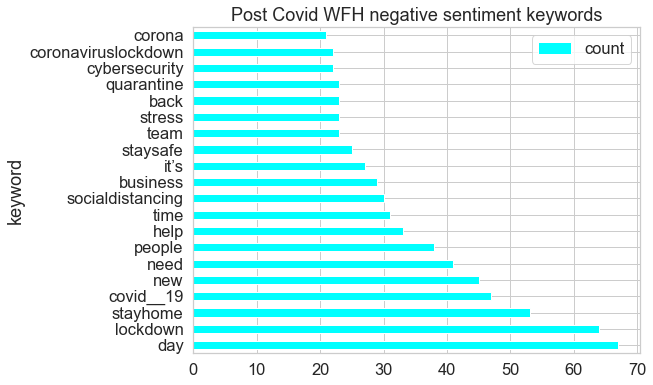

In [180]:
# Top 20 keywords for negative sentiment post covid
fig, ax = plt.subplots(figsize=(8, 6))

# Plot horizontal bar graph
freq_df.sort_values(by='count', ascending=False)[:20].plot.barh(x='keyword',
                      y='count',
                      ax=ax,
                      color="aqua")
ax.set_title("Post Covid WFH negative sentiment keywords")

plt.show()